In [292]:
# Pronóstico de Series de Tiempo
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [302]:
url='https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_spo_DailyData.txt'
df = pd.read_csv(url, encoding='cp1251', sep='\s+', header=None, skiprows=150, skipfooter=1, engine='python')

df = df.drop(0,axis=0)

df['Fecha'] = df[3].map(str) + '/' + df[2] + '/' + df[1]
df['Fecha'] = pd.to_datetime(df["Fecha"],dayfirst=True,errors ='coerce')
df['Año'] = df['Fecha'].dt.year
df['Mes'] =df['Fecha'].dt.month
df['Día'] =df['Fecha'].dt.day
df = df.set_index('Fecha')

df=df.drop(range(0, 8), axis=1)
df=df.drop(range(9, 17), axis=1)

df[8]=df[8].astype(float)

df=df.replace(to_replace=-999.99, value=np.nan, regex=True)

df.columns=['Value', 'Año', 'Mes', 'Dia']

df_30=df[(df['Año']>=1980) & (df['Año']<2019)].copy()
df_30.ffill(axis=0, inplace=True)

df_30.head(100)

,Value,Año,Mes,Dia
Fecha,,,,
1980-01-01,336.30,1980,1,1
1980-01-02,336.28,1980,1,2
1980-01-03,336.21,1980,1,3
1980-01-04,336.19,1980,1,4
1980-01-05,336.20,1980,1,5
...,...,...,...,...
1980-04-05,336.20,1980,4,5
1980-04-06,336.22,1980,4,6
1980-04-07,336.23,1980,4,7


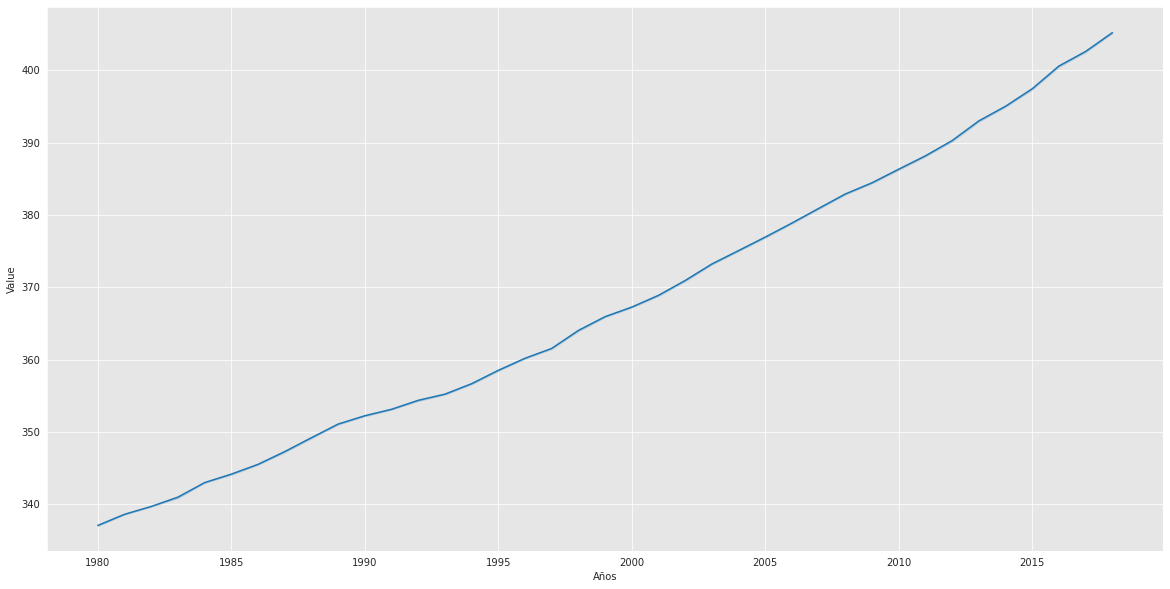

In [246]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(20,10))

sns.lineplot(x='Año', y='Value', data=df1)
plt.xlabel('Años')
plt.ylabel('Value')
plt.show()

In [293]:
# Definimos una función para probar la Estacionaridad de una Serie de Tiempo usando la Prueba Aumentada de Dickey-Fuller(ADF)

# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='yellow',label='Original')
    plt.plot(rolmean, color='blue', label='Rolling Mean')
    plt.plot(rolstd, color='green', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [294]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1980 a 2019
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '1980-01', '2019-12'

ts_30 = df_30.loc[start:end].copy()
ts_30.head()

,Value,Año,Mes,Dia
Fecha,,,,
1980-01-01,336.30,1980,1,1
1980-01-02,336.28,1980,1,2
1980-01-03,336.21,1980,1,3
1980-01-04,336.19,1980,1,4
1980-01-05,336.20,1980,1,5


In [295]:
# Vemos su encabezado
ts_30['Value'].head()

Fecha
1980-01-01    336.30
1980-01-02    336.28
1980-01-03    336.21
1980-01-04    336.19
1980-01-05    336.20
Name: Value, dtype: float64

In [296]:
ts_test = ts_30['Value'].copy()

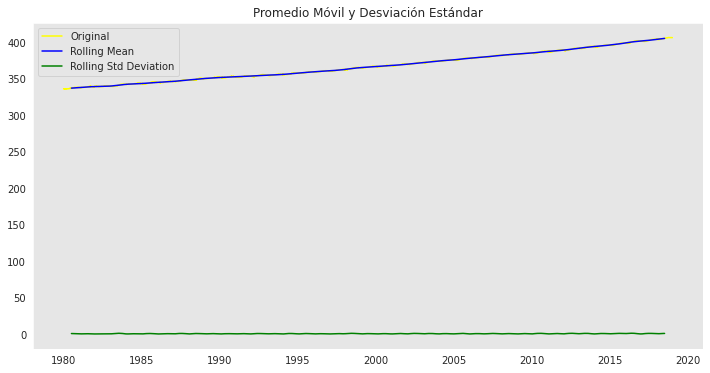

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     1.040077
p-value                            0.994671
#Lags Used                        42.000000
Number of Observations Used    14202.000000
Critical Value (1%)               -3.430811
Critical Value (5%)               -2.861744
Critical Value (10%)              -2.566878
dtype: float64


In [297]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test)

El avlor de p está muy por encima del 0.05 lo cual nos prohibe asegurar que es una serie estacionaria, hay que probar algunos métodos.

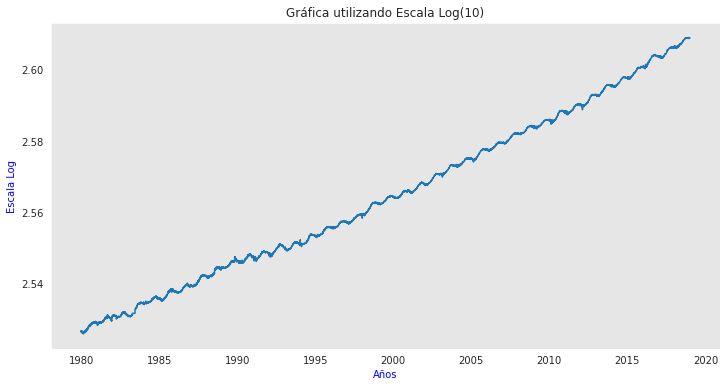

In [267]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

Ahora el promedio móvil

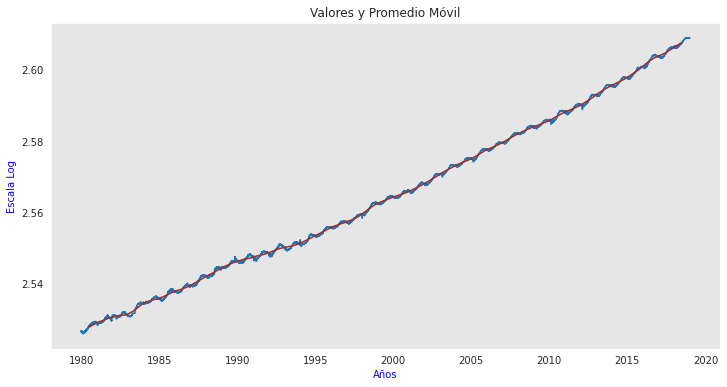

In [268]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [269]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: Value, dtype: float64

In [270]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01    0.000184
1980-07-02    0.000229
1980-07-03    0.000249
1980-07-04    0.000255
1980-07-05    0.000313
Name: Value, dtype: float64

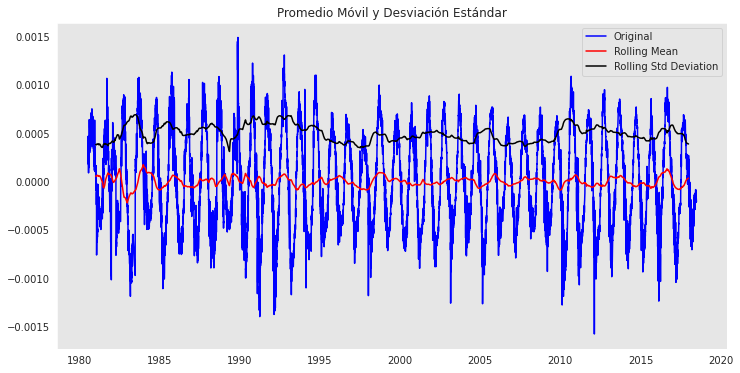

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.117304e+01
p-value                        2.611637e-20
#Lags Used                     4.200000e+01
Number of Observations Used    1.383800e+04
Critical Value (1%)           -3.430823e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [271]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

Con p<0.05 ya se puede afirmar que es estacionaria

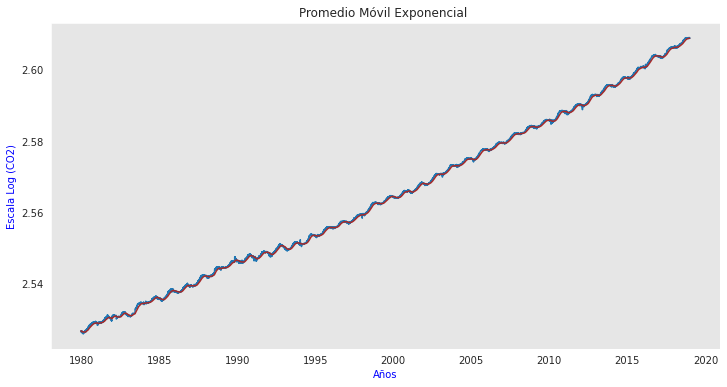

In [303]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log (CO2)',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();


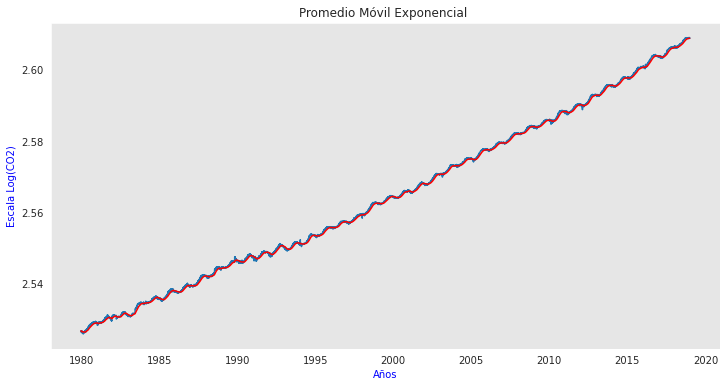

In [305]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'red')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log(CO2)',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [274]:
EWM_avg.head()

Fecha
1980-01-01    2.526727
1980-01-02    2.526714
1980-01-03    2.526679
1980-01-04    2.526654
1980-01-05    2.526642
Name: Value, dtype: float64

In [275]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

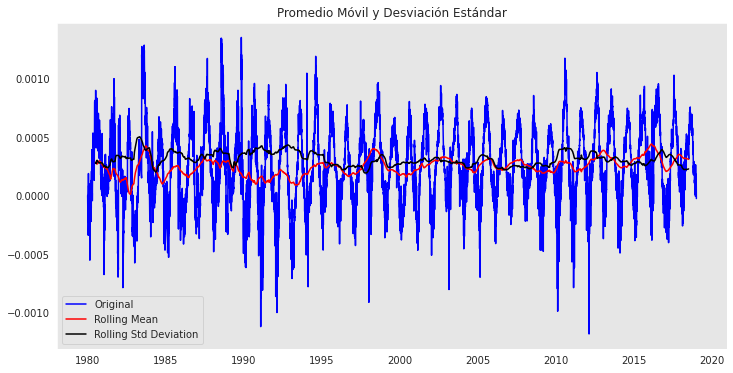

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.485483e+00
p-value                        3.772881e-16
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [276]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)

Ahora ya se puede afirmar que es estacionaria en un 99%

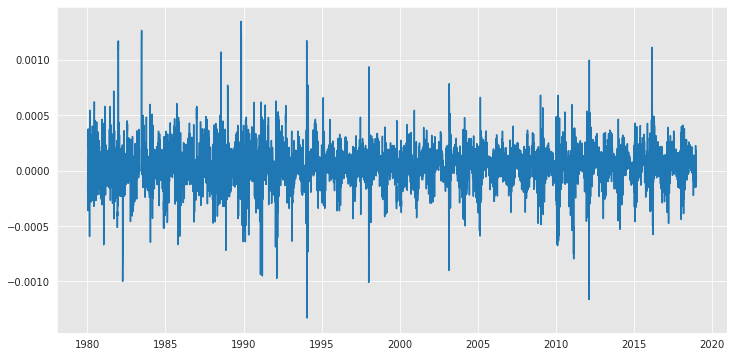

In [277]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

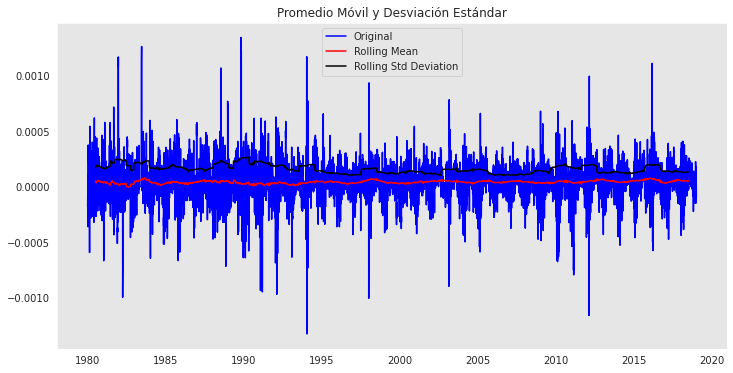

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.164723e+01
p-value                        2.078172e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.419500e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [278]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

Ya es una serie estacionaria, el número se hace más pequeño. Cada vez hay menos variación.

In [279]:
# Número de datos utilizados
len(ts_test_log_diff)

14238

La actividad no lo pide pero me gustaría usar el método de descomposición solo para un análisis más profundo.

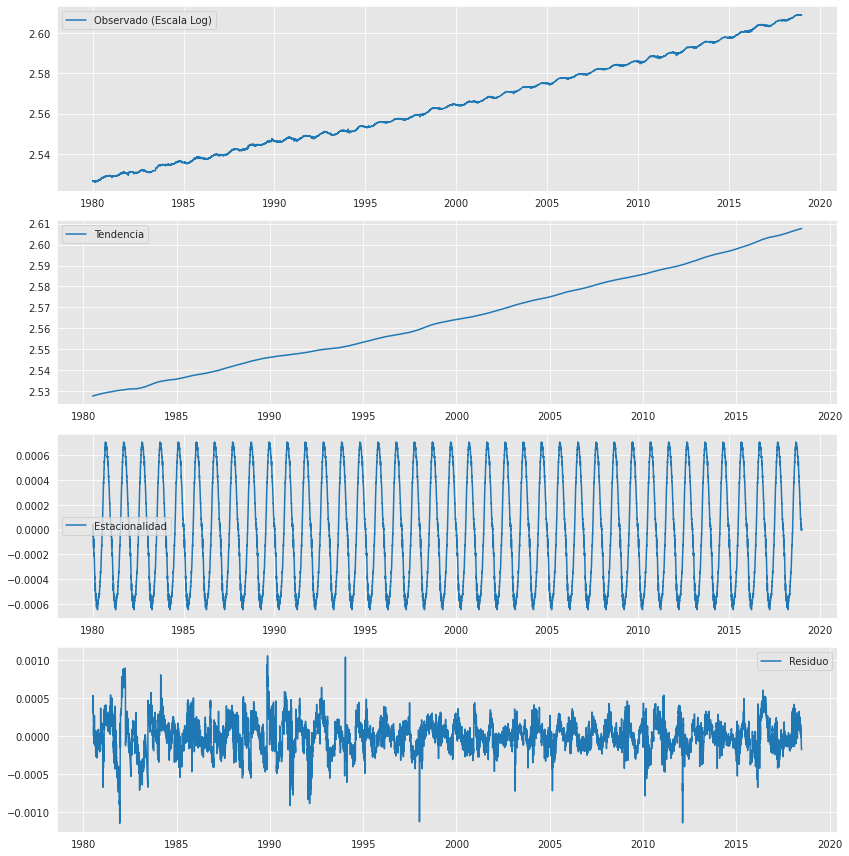

In [280]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

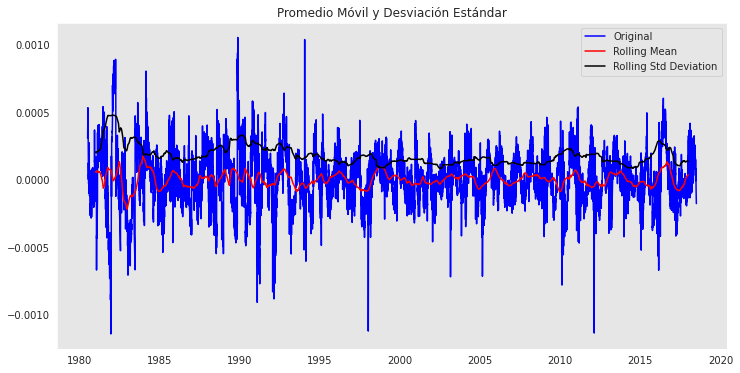

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.114891e+01
p-value                        2.977546e-20
#Lags Used                     3.000000e+01
Number of Observations Used    1.385000e+04
Critical Value (1%)           -3.430822e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [281]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

Comprobado serie de tiempo estacionaria

Método de predicción de los datos

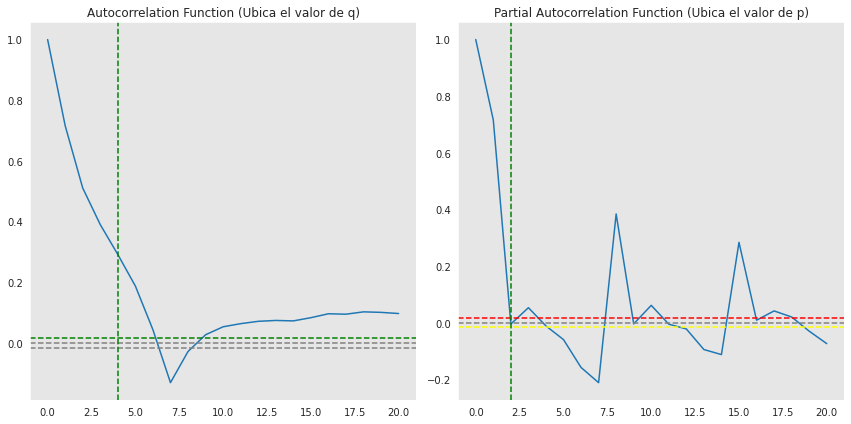

In [306]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='yellow')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='red')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14244
Model:                 ARIMA(2, 1, 0)   Log Likelihood              113194.841
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -226381.683
Time:                        07:00:08   BIC                        -226351.426
Sample:                    01-02-1980   HQIC                       -226371.619
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.766e-06   5.39e-07     10.706      0.000    4.71e-06    6.82e-06
ar.L1.D.Value    -0.1568      0.008    -19.010      0.000      -0.173      -0.141
ar.L2.D.Value    -0.1750      0.008    -

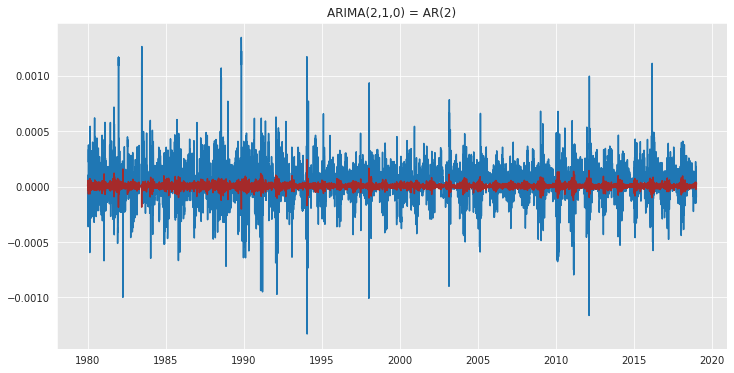

In [283]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14244
Model:                 ARIMA(0, 1, 4)   Log Likelihood              113297.651
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -226583.301
Time:                        07:00:32   BIC                        -226537.917
Sample:                    01-02-1980   HQIC                       -226568.205
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.766e-06   4.15e-07     13.892      0.000    4.95e-06    6.58e-06
ma.L1.D.Value    -0.1972      0.008    -23.651      0.000      -0.214      -0.181
ma.L2.D.Value    -0.1765      0.009    -

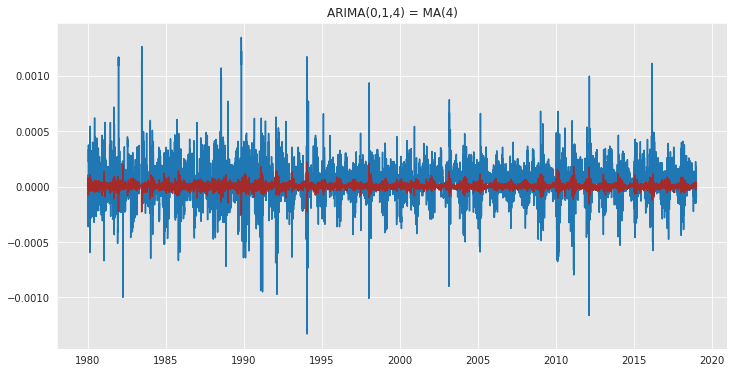

In [284]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14244
Model:                 ARIMA(2, 1, 4)   Log Likelihood              113299.607
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -226583.214
Time:                        07:01:01   BIC                        -226522.701
Sample:                    01-02-1980   HQIC                       -226563.086
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.771e-06   4.25e-07     13.588      0.000    4.94e-06     6.6e-06
ar.L1.D.Value     0.1932        nan        nan        nan         nan         nan
ar.L2.D.Value    -0.1302      0.075     

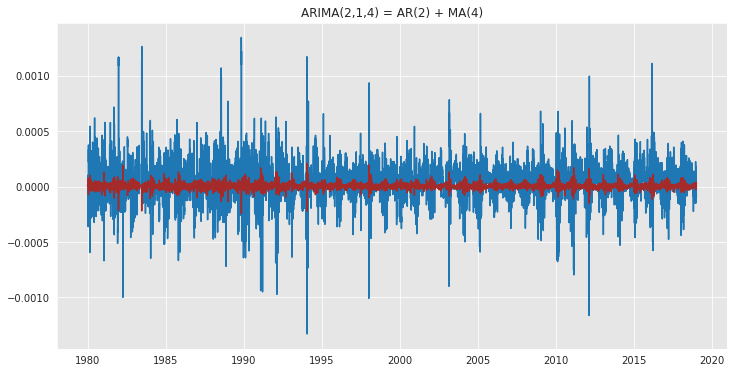

In [285]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

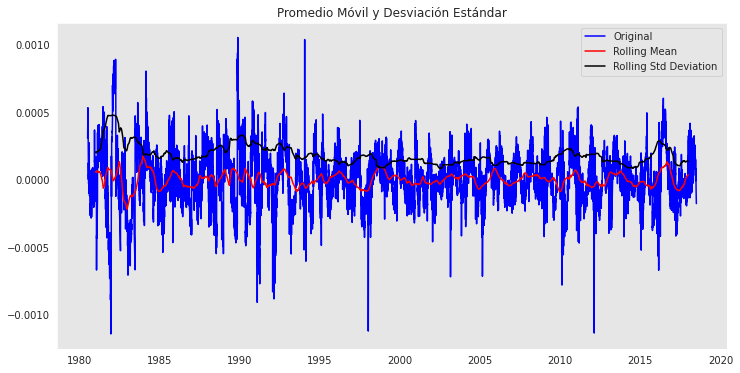

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.114891e+01
p-value                        2.977546e-20
#Lags Used                     3.000000e+01
Number of Observations Used    1.385000e+04
Critical Value (1%)           -3.430822e+00
Critical Value (5%)           -2.861749e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [286]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

In [287]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1980-01-02    0.000006
1980-01-03    0.000010
1980-01-04    0.000026
1980-01-05    0.000033
1980-01-06    0.000023
                ...   
2018-12-27   -0.000006
2018-12-28   -0.000005
2018-12-29    0.000007
2018-12-30    0.000035
2018-12-31    0.000026
Length: 14244, dtype: float64


In [288]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    2.526707
1980-01-03    2.526621
1980-01-04    2.526611
1980-01-05    2.526630
dtype: float64
Fecha
2018-12-27    2.609023
2018-12-28    2.608970
2018-12-29    2.608865
2018-12-30    2.608946
2018-12-31    2.608852
dtype: float64


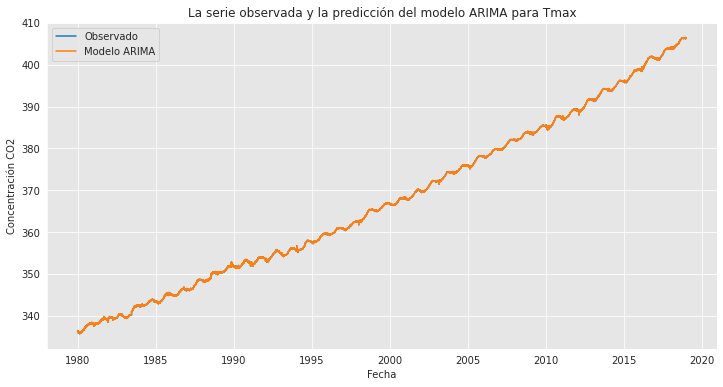

In [300]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Concentración CO2')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [290]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.018939538358052045


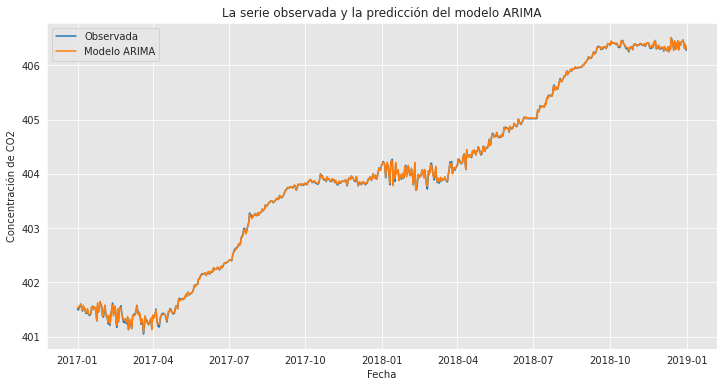

In [301]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Concentración de CO2')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');